<span style="font-size:110%; text-align:left;"><b><a href="../index.html">2. Plane Waves</a> > <a href="./index.html">4. Demodulation</a></b></span>
<br/><br/>
<span style="font-size:200%; text-align:left;"><b>Double Demodulation</b></span>
<br/><br/>
<span style="font-size:110%; text-align:left;">Author: Daniel Töyrä </span>

<img src="files/double_demodulation.svg" style="width: 700px;" align="center"/>

# Table of Contents
 <p><div class="lev1"><a href="#1.-Introduction">1. Introduction</a></div><div class="lev1"><a href="#2.-Double-demodulation">2. Double demodulation</a></div><div class="lev2"><a href="#2.1.-Simulation-example">2.1. Simulation example</a></div><div class="lev1"><a href="#3.-Tasks">3. Tasks</a></div><div class="lev2"><a href="#3.1.-Reconstruct-amplitude-and-phase-of-a-double-demodulated-signal">3.1. Reconstruct amplitude and phase of a double demodulated signal</a></div><div class="lev1"><a href="#4.-Tasks-with-answers">4. Tasks with answers</a></div><div class="lev2"><a href="#4.1.-Reconstruct-amplitude-and-phase-of-a-double-demodulated-signal">4.1. Reconstruct amplitude and phase of a double demodulated signal</a></div><div class="lev1"><a href="#5.--Summary">5.  Summary</a></div>

# 1. Introduction

Double demodulation is a technique of extracting the information modulated on an already modulated carrier. For example, we can on purpose modulate the carrier field once to create sidebands for controlling an interferometer (which we will see in later notebooks). The modulated field can then be modulated again, either on purpose or due to some external wanted or unwanted process, such as interaction with gravitational waves or due to noise. This second modulation effectively creates sidebands around the already present frequency components, as seen in the figure in the next section. When demodulating twice, once on each modulation frequency, we can extract the amplitude and phase information of the 'sidebands' of the 'carrier sidebands'. Double demodulation can be described as mixing the field with two local oscillators instead of one as was the case for single demodulation.

** Recommended notebooks before you start:**

We recommend that you have looked through the notebook 01_Single_demodulation that you find in the folder [02_Plane_waves/04_Demodulation](../04_Demodulation/index.html) before you start this one, or that you have basic experience of IPython/Jupyter Notebooks, PyKat, Finesse, and modulation/demodulation. The link above only works if you started IPython/Jupyter Notebook in the top directory of this course.

**Reading material and references:**

[1] [A. Freise, K. Strain, D. Brown, and C. Bond, "Interferometer Techniques for Gravitational-Wave Detection", *Living Reviews in Relativity* **13**, 1 (2010)](http://arxiv.org/pdf/0909.3661v3). - Living review article (more like a book) on laser interferometry in the frequency domain for detecting gravitational waves, and FINESSE.

[2] [A. Freise, D. Brown, and C. Bond, "Finesse, Frequency domain INterferomEter Simulation SoftwarE"](http://kvasir.sr.bham.ac.uk/redmine/attachments/download/131/Finesse_2.0_manual.pdf). - FINESSE-manual

[3] [FINESSE syntax reference](http://www.gwoptics.org/finesse/reference/) - Useful online syntax reference for FINESSE. Also available in the Finesse manual [2], but this online version is updated more frequently.

** After this session you will... **

* have used the FINESSE component `pd2` to double demodulate a double amplitude modulated laser field.
* have seen that by using two double demodulation schemes, with the second demodulation phases 90 degrees shifted from each other, one can extract the full amplitude and phase of the double demodulation signal.

# 2. Double demodulation

Importing PyKat and other Python packages that we need, and setting up how to display figures.

In [2]:
import numpy as np                         # Importing numpy
import matplotlib                          # For plotting
import matplotlib.pyplot as plt                   
from pykat import finesse                  # Importing the pykat.finesse package
from pykat.commands import *               # Importing all packages in pykat.commands.
from IPython.display import display, HTML  # Allows us to display HTML.

# Telling the notebook to make plots inline.
%matplotlib inline      
# Initialises the PyKat plotting tool. Change the dpi value 
# to adjust size of figures on your screen.
pykat.init_pykat_plotting(dpi=90)          

                                              ..-
    PyKat 1.0.6           _                  '(
                          \`.|\.__...-""""-_." )
       ..+-----.._        /  ' `            .-'
   . '            `:      7/* _/._\    \   (
  (        '::;;+;;:      `-"' =" /,`"" `) /
  L.        \`:::a:f            c_/     n_'
  ..`--...___`.  .    ,  
   `^-....____:   +.      www.gwoptics.org/pykat



<img src="files/double_sidebands.svg" style="width: 600px;" align="center"/>

An example of an application of double demodulation is to compute how sensitive an interferometry control system is to an external signal, such as a gravitational wave, seismic noise, laser amplitude noise, laser frequency noise, quantum noise, and so on. The first modulation-demodulation scheme creates a control signal, where both the amplitude, phase and frequency of the scheme is user defined and well controlled. The second demodulation extracts information about how the control signal is affected by the external signal. The phase and amplitude of this external signal may be unknown, but just as for single demodulation we can demodulate in-phase and in-quadrature to extract both the amplitude and phase information of it.  More on this in later notebooks on interferometry control systems. A double demodulation scheme can be broken down as follows:

* Modulate the carrier field twice. This can be done by an electro-optic modulator, some noise source, a gravitational wave etc. The first modulation creates the blue sidebands in the figure above, and the second creates the black and green sidebands.
* Detect the power by using a photo diode
* Demodulate the power signal with a user-defined local oscillator of frequency $\omega_x$ and phase $\varphi_x$. This step is performed by an electronic mixer, mathematically this means that the power signal is multiplied with $\cos(\omega_x t + \varphi_x)$. 
* Mix the resultant signal again, this time with a signal of frequency $\omega_y$ and phase $\varphi_y$.
* Low-pass filter the signal so that only the DC part remains. The output is a DC-signal that is proportional to the amplitudes of the blue and green sidebands in the figure above.

Assuming that we already know the optimal demodulation phase $\varphi_x$ for the blue sidebands, we can by using two mixers in parallel, phase shifted 90 degrees from each other, reconstruct the phase of the demodulation signal, and subsequently obtain the phase and amplitude of the green sidebands in the figure.

You can read more about double demodulation in section 4.2. in the living review article [1]. Here we jump into a FINESSE example.

## 2.1. Simulation example

<img src="files/double_demodulation.svg" style="width: 500px;" align="center"/>

In this Finesse example a carrier field is amplitude modulated twice by using electro-optic modulators (EOM) (keyword `mod`). We first build our optical model consisting of an input laser, an two EOMs in series. The first one amplitude modulates the carrier field on 1 MHz with 20 degrees modulation phase, the second one amplitude modulates the field on 1 kHz with a modulation phase of 60 degrees.  We also add an empty space between all components, as well as after the second EOM, which will soon connect the EOM with the detectors as seen in the figure above.

In [151]:
basekat = finesse.kat()          # Initialising Finesse
basekat.verbose = False          # Tells Finesse to talk less

basecode = """
## The optical system ##

l laser 100 0 n0               # Laser (P = 100 W, Freq. offset = 0 Hz)
s s1 1 n0 n1                   # Space, laser to EOM (L = 1 m)
mod eom1 1M 0.5 1 am 20 n1 n2  # Modulator (f = 1 MHz, m=0.5, 1 sideband pair, 
                               # type = amplitude modulation, phase = 20 deg.)
s s2 1 n2 n3                   # Space, eom1 to eom2 (L = 1 m)
mod eom2 1k 0.3 1 am 60 n3 n4  # Modulator (f = 1 kHz, m=0.3, 1 sideband pair, 
                               # type = amplitude modulation, phase = 60 deg.)
s s3 1 n4 n5                   # Space, eom2 to output (L = 1 m)

"""
# Parsing the FINESSE-code
basekat.parseCommands(basecode)

We treat the first modulation as made on purpose, for example to create sidebands for controlling the interferometer. Thus, we measure the optimal demodulation phase once and we expect it to stay the same during operation. For this, we use single demodulation on 1 MHz, and as we learned in the previous notebook we can extract the phase of the output signal by using two demodulation schemes in parallel, with local oscillators phase shifted 90 degrees from each other.

In [152]:
kat1a = basekat.deepcopy()

code = """
## Detectors ##
pd1 inphase 1M 0 n5    # Photodiode + mixer + low pass filter 
                       # (f1 = 1 MHz, phi1 = 0 deg)
pd1 inquad 1M 90 n5    # Photodiode + mixer + low pass filter 
                       # (f1 = 1 MHz, phi1 = 90 deg)

## Simulation Instructions ##
noxaxis                # No xaxis. Computing just one data point.
yaxis abs              # Returns absolute values of detector outputs
"""

# Parsing the code and running the simulation
kat1a.parseCommands(code)
out1a = kat1a.run()

Now we reconstructing the full complex signal, and computing the phase of it:

In [156]:
# Reconstructing full complex demodulation signal
S1 = out1a['inphase'] + 1j*out1a['inquad']
# Calculating the phase
phase1 = np.angle(S1)*180.0/np.pi
print('Optimal demodulation phase at 1 MHz: {:f} deg'.format(phase1))

Optimal demodulation phase at 1 MHz: 17.598339 deg


Maybe you expected the phase to be 20 degrees? If would have measured this immediately after the modulator it would have been, but we measure it 2 meters later, and the 1 MHz difference between the carrier and the sideband creates an extra phase shift. 

With this information, we go to double demodulation. We will here use three different demodulation schemes, which we in FINESSE can put at the exact same node simultaneously. In reality we would need to divide the power signal into three parts, but this is not necessary in a simulation. The power is in all three cases measured by a photodiode. After the power is measured we demodulate (mix) the power signal twice. Once on 1 MHz with the demodulation phase obtained above ($\varphi_x = 17.598$ Hz), and once the frequency 1 kHz. The second demodulation is performed with a different demodulation phase in each of the three demodulation schemes: $\varphi_y = 0$ which we call in-phase, $\varphi_y = 90$ degrees which we call in-quadrature, and $\varphi_x = $ `max`, which automatically uses the optimal demodulation phase. After mixing with local oscillators, we low pass filter our signals so that only the DC-parts remain. These four steps (photo diode + mixing1 + mixing2 + low pass filter) are performed by the the FINESSE components with the keyword `pd2`, where `2` stands for double demodulation. While doing these measurement, we are varying the modulation index of `eom2`. 

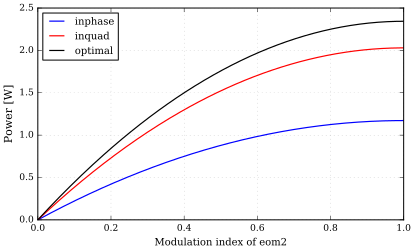

In [162]:
kat1b = basekat.deepcopy()

code = """
## Detectors ##
pd2 inphase 1M {0} 1k 0 n5     # Photodiode + mixer + low pass filter 
                               # (f1 = 1 MHz, phi1 = 20 deg, 
                               #  f2 = 1 kHz, phi2 = 0 deg)
pd2 inquad 1M {0} 1k 90 n5     # Photodiode + mixer + low pass filter 
                               # (f1 = 1 MHz, phi1 = 20 deg, 
                               #  f2 = 1 kHz, phi2 = 90 deg)
pd2 optimal 1M {0} 1k max n5   # Photodiode + mixer + low pass filter 
                               # (f1 = 1 MHz, phi1 = 20 deg, 
                               #  f2 = 1 kHz, phi2 = max)

## Simulation Instructions ##
xaxis eom2 midx lin 0 1 200    # Varying EOM modulation between 0 and 1
yaxis abs                      # Returns absolute values of detector outputs
""".format(phase1)

# Parsing the code and running the simulation
kat1b.parseCommands(code)
out1b = kat1b.run()
# Plotting the detector outputs
fig1b = out1b.plot(xlabel='Modulation index of eom2', 
                   ylabel='Power [W]')

The figure shows three traces with different second demodulation phases $\varphi_y$. The one called in phase has $\varphi_y = 0$ and the one called quadrature has $\varphi_x = 90~\mathrm{degrees})$. For the trace called optimal we used the FINESSE command `max` to automatically get the maximum output for each data point. As we can see, the optimal trace gives the largest output for all modulation indices, as expected. Now we reconstruct the full complex signal using our in-phase and in-quadrature detector outputs according to 

\begin{align}
S_2 = 2_{2,\mathrm{phase}} + iS_{2,\mathrm{quad}}~.
\end{align}

To see why, see section 4.2. in the living review article [1]. We compare the magnitude of this reconstructed signal with the optimal "cheat" signal obtained directly from FINESSE. 

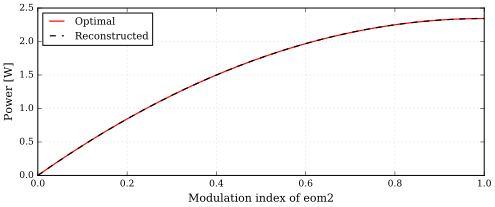

Phase of S2: 59.9988 deg


In [177]:
# Reconstructing
S2 = out1b['inphase'] + 1j*out1b['inquad']

## Plotting ##

# Plotting the the absolute value
fig1c = plt.figure(figsize = (8,3))
ax = plt.subplot(1,1,1)
ax.plot(out1b.x, np.abs(out1b['optimal']), 
        'r-', label='Optimal')
ax.plot(out1b.x, np.abs(S2), 
        'k--', label='Reconstructed')
ax.set_ylabel('Power [W]')
ax.set_xlabel('Modulation index of eom2')
ax.set_title('')
ax.legend(loc=0, fontsize=10)
'''
# Plotting the phase (Converting from radians to degrees)
ax2 = plt.subplot(2,1,2)
ax2.plot(out1b.x, np.angle(out1b['optimal'])*180/np.pi, 'r-', label='Optimal')
ax2.plot(out1b.x, np.angle(S2)*180/np.pi, 'k--', label='Reconstructed')
ax2.set_xlabel('Modulation index of eom2')
ax2.set_ylabel('Phase [deg]')
ax2.set_ylim((0,70))
ax2.legend(loc=0, fontsize=10)
'''
plt.show()

# Calculating and printing the phase of S2 in degrees
phase2 = np.angle(S2[1])*180/np.pi
print('Phase of S2: {:.4f} deg'.format(phase2))

We see that our reconstructed signal exactly follows the signal obtained by using the "cheat" phase `max`. The phase only deviated slightly from the 60 degrees modulation phase. This is because the frequency difference between the carrier and the sideband only is 1 kHz in this case, and 1 meter is not enough for building up a significant phase shift for this small frequency deviation. To explicitly show that the phase is reconstructed as well we wait until the task below.

In FINESSE you can always "cheat" and obtain the optimal trace by using the keyword `max`, as seen above. However, we would recommend to manually find the optimal demodulation phase as it is safer for complicated setups. You can even obtain the full complex demodulation signal directly by leaving the spot for demodulation phase empty, and using `yaxis abs:deg`, which we will see below in the task.

# 3. Tasks

## 3.1. Reconstruct amplitude and phase of a double demodulated signal

Modify the example above to extract both the amplitude and phase of $S_2$, both by reconstructing it from the in-phase and in-quadrature measurements as in the example, but also by directly obtaining the full complex representation of $S_2$ using FINESSE code.

**Answer:**

# 4. Tasks with answers

## 4.1. Reconstruct amplitude and phase of a double demodulated signal

Modify the example above to extract both the amplitude and phase of $S_2$, both by reconstructing it from the in-phase and in-quadrature measurements as in the example, but also by directly obtaining the full complex representation of $S_2$ using FINESSE code.

**Answer:**

We need to change two things from the example code:
* Remove `max` from the second demodulation phase of the `pd2` detector `optimal`, and leave it empty. If the `yaxis` allows it, this detector will then output the complex representation of $S_2$.
* Switch to `yaxis abs:deg` to obtain the full complex representation of the detector `optimal`.

In [193]:
kat2 = basekat.deepcopy()

code = """
## Detectors ##
pd2 inphase 1M {0} 1k 0 n5     # Photodiode + mixer + low pass filter 
                               # (f1 = 1 MHz, phi1 = 20 deg, 
                               #  f2 = 1 kHz, phi2 = 0 deg)
pd2 inquad 1M {0} 1k 90 n5     # Photodiode + mixer + low pass filter 
                               # (f1 = 1 MHz, phi1 = 20 deg, 
                               #  f2 = 1 kHz, phi2 = 90 deg)
pd2 optimal 1M {0} 1k n5       # Photodiode + mixer + low pass filter 
                               # (f1 = 1 MHz, phi1 = 20 deg, 
                               #  f2 = 1 kHz, phi2 = max)

## Simulation Instructions ##
xaxis eom2 midx lin 0 1 200    # Varying EOM modulation between 0 and 1
yaxis abs:deg                  # Returns absolute values of detector outputs
""".format(phase1)

# Parsing the code and running the simulation
kat2.parseCommands(code)
out2 = kat2.run()

Now we reconstruct the complex $S_2$ from the detectors `inphase` and `inquad`, and compare both the amplitude and phase to the output of the detector `optimal`. 

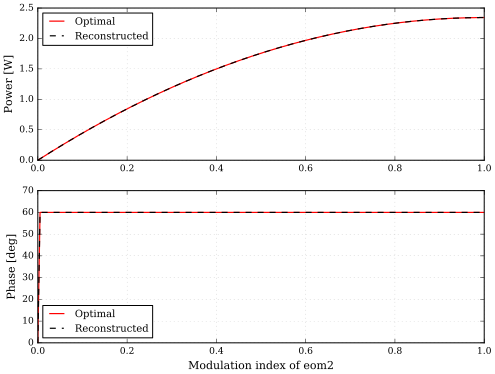

Reconstructed phase: 59.99879916925727 deg
Optimal phase:       59.99879916925731 deg


In [194]:
# Reconstructing
S2 = out2['inphase'] + 1j*out2['inquad']

## Plotting ##

# Plotting the the absolute value
fig2 = plt.figure(figsize = (8,6))
ax = plt.subplot(2,1,1)
ax.plot(out2.x, np.abs(out2['optimal']), 
        'r-', label='Optimal')
ax.plot(out2.x, np.abs(S2), 
        'k--', label='Reconstructed')
ax.set_ylabel('Power [W]')
ax.set_title('')
ax.legend(loc=0, fontsize=10)

# Plotting the phase (Converting from radians to degrees)
ax2 = plt.subplot(2,1,2)
ax2.plot(out1b.x, np.angle(out1b['optimal'])*180/np.pi, 'r-', label='Optimal')
ax2.plot(out1b.x, np.angle(S2)*180/np.pi, 'k--', label='Reconstructed')
ax2.set_xlabel('Modulation index of eom2')
ax2.set_ylabel('Phase [deg]')
ax2.set_ylim((0,70))
ax2.legend(loc=0, fontsize=10)

plt.show()

# Calculating and printing the phase of S2 in degrees
phase2_rec = np.angle(S2[1])*180/np.pi
phase2_opt = np.angle(out2['optimal'][1])*180/np.pi
print('Reconstructed phase: {:.14f} deg'.format(phase2_rec))
print('Optimal phase:       {:.14f} deg'.format(phase2_opt))

As we see in the figure, we have computed the amplitude and phase of the double demodulation signal $S_2$, both by using the realistic measurements by the `pd2` detectors `inphase` and `inquadrature`, and by the FINESSE "cheat" of leaving the second demodulation phase empty for the `pd2` detector `optimal`. And as we see in the figures above, the the ways agree perfectly.

# 5.  Summary

In this session we have:
* used a photo diode in combination with two mixers and a low pass filter to double demodulate a double amplitude modulated carrier field.
* seen that the full double demodulation signal can be extracted by two double demodulation schemes, with the second demodulation phases 90 degrees apart from each other. 